In [24]:
#The Following cell of code is used everytime FASTAI library is used.
#They tell the notebook to reload any changes made to any libraries used.
#They also ensure that any graphs are plotted are shown in this notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [25]:
from fastai.vision.all import *
from fastai.metrics import *
import pandas as pd
from pathlib import Path

In [26]:
meta_df = pd.read_csv("../data/meta_data.csv")
meta_df.sort_values(by='image_id')

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,age_group,class
4349,4349,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk,middle age,benign
4263,4263,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity,middle age,benign
4217,4217,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk,middle age,benign
3587,3587,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk,middle age,benign
1451,1451,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest,0ld,malignant
...,...,...,...,...,...,...,...,...,...,...
1721,1721,HAM_0004304,ISIC_0034316,mel,histo,85.0,male,upper extremity,0ld,malignant
1888,1888,HAM_0006376,ISIC_0034317,mel,histo,70.0,female,lower extremity,0ld,malignant
121,121,HAM_0000344,ISIC_0034318,bkl,histo,55.0,male,trunk,middle age,benign
7440,7440,HAM_0000747,ISIC_0034319,nv,histo,30.0,male,trunk,adult,benign


In [27]:
path = Path('../data')
Path.BASE_PATH = path
path.ls()

(#10) [Path('class'),Path('HAM10000_images'),Path('HAM10000_images_part_1'),Path('HAM10000_images_part_2'),Path('HAM10000_metadata.csv'),Path('hmnist_28_28_L.csv'),Path('hmnist_28_28_RGB.csv'),Path('hmnist_8_8_L.csv'),Path('hmnist_8_8_RGB.csv'),Path('meta_data.csv')]

In [28]:
class_encoding = {'benign':0, 'malignant':1}

In [29]:
# returns only dx and image id column
img_to_class_dict = meta_df.loc[:, ["image_id", "class"]] 
# returns columns as lists in a dict
img_to_class_dict = img_to_class_dict.to_dict('list')  
# returns a dict mapping image id to disease name
img_to_class_dict = {img_id : class_encoding[disease] for img_id,disease in zip(img_to_class_dict['image_id'], img_to_class_dict['class']) } 
[x for x in img_to_class_dict.items()][:10]
# img_to_class_dict['image_id']

[('ISIC_0027419', 0),
 ('ISIC_0025030', 0),
 ('ISIC_0026769', 0),
 ('ISIC_0025661', 0),
 ('ISIC_0031633', 0),
 ('ISIC_0027850', 0),
 ('ISIC_0029176', 0),
 ('ISIC_0029068', 0),
 ('ISIC_0025837', 0),
 ('ISIC_0025209', 0)]

In [30]:
# path.stem returns the filename without suffix
def get_label_from_dict(path):
    return img_to_class_dict[path.stem] 

In [32]:
dblock = DataBlock(
    # Designation the independent and dependent variables
    blocks = (ImageBlock, CategoryBlock), 
    # To get a list of those files,and returns a list of all of the images in that path
    get_items = get_image_files, 
    # Split our training and validation sets randomly
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    # We are telling fastai what function to call to create the labels in our dataset, in our case is independet variable
    get_y = get_label_from_dict,
    # DihedralItem all 4 90 deg roatations and for each: 
    #2 horizonntal flips -> 8 orientations
    item_tfms=[Resize(448), DihedralItem()],
    # Picks a random scaled crop of an image and resize it to size
    batch_tfms=RandomResizedCrop(size=224, min_scale=0.75, max_scale=1.0))

img_path = "../data/HAM10000_images"
# create dataloader using img_path   
dls = dblock.dataloaders(img_path, bs=64)

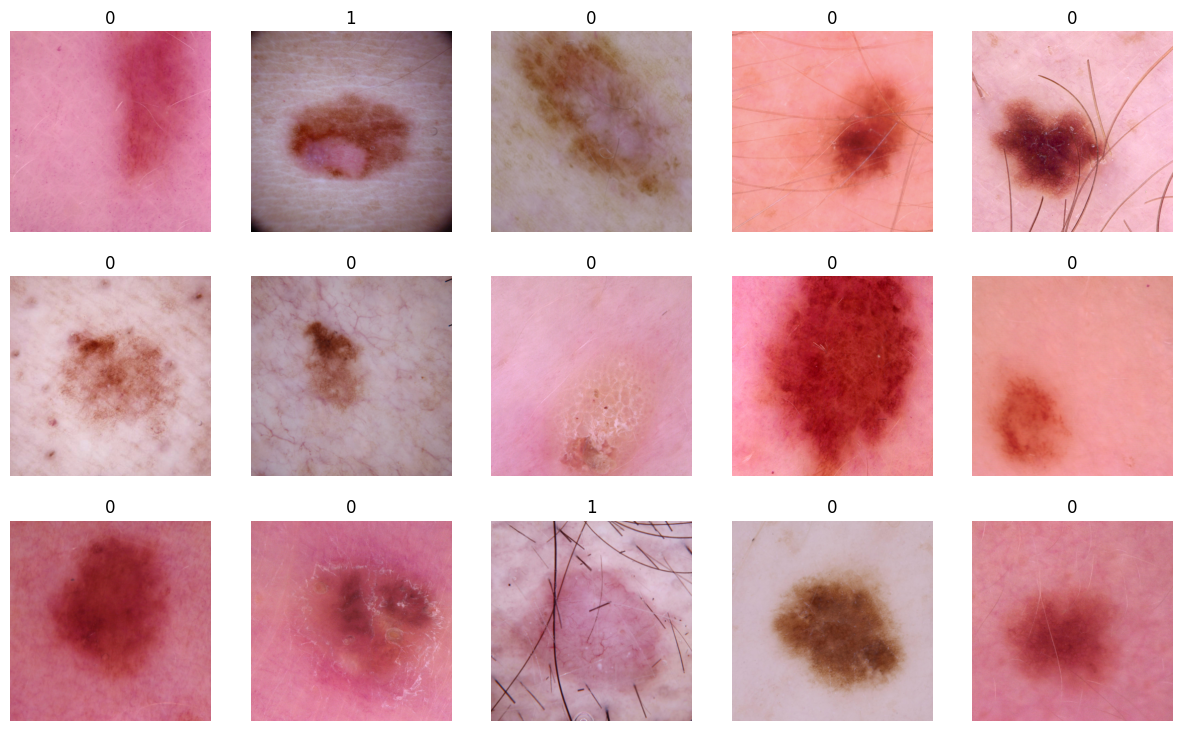

In [33]:
dls.show_batch(max_n=15)

In [34]:
print(dls.vocab)

[0, 1]


In [35]:
len(dls.train_ds), len(dls.valid_ds)

(8012, 2003)

In [36]:
learn = vision_learner(dls,
                    resnet18,
                    metrics=accuracy)
learn.fine_tune(4)

c:\Users\32467\anaconda3\envs\cv_env\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\32467\anaconda3\envs\cv_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\32467/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 25.2MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.651062,0.440520,0.800799,32:46


epoch,train_loss,valid_loss,accuracy,time
0,0.405322,0.338049,0.859211,40:01
1,0.325089,0.268986,0.885172,38:55
2,0.273679,0.251485,0.894658,1:57:51
3,0.230795,0.249202,0.891163,44:16


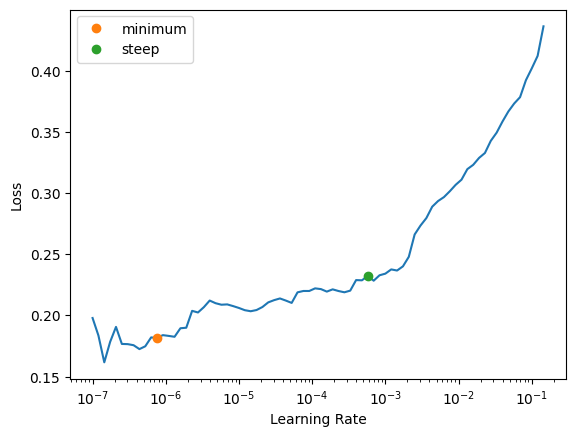

In [37]:
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [38]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 7.59e-08, steepest point: 5.75e-04


In [39]:
learn = vision_learner(dls,resnet34, metrics = accuracy)
learn.fit_one_cycle(3,1e-2) 

c:\Users\32467\anaconda3\envs\cv_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\32467/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:11<00:00, 7.60MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.528493,0.411372,0.846730,1:06:10
1,0.365932,0.324780,0.848727,59:28
2,0.285134,0.269214,0.878682,58:20


In [40]:
learn.unfreeze()


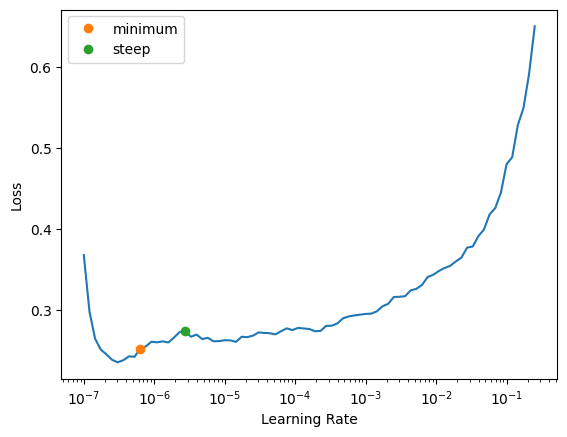

In [41]:
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

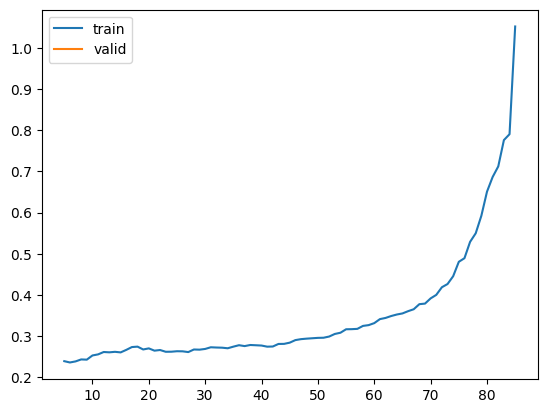

In [42]:
learn.recorder.plot_loss()

In [45]:
learn.export('fastai_model.pkl')


In [50]:
learn=load_learner('fastai_model.pkl')

#img = dls.train_ds[6][0]
img ="../data/HAM10000_images/test_1.jpg"
learn.predict(img)[0]

'0'

In [43]:
#learn.save('model1')

Path('models/model1.pth')

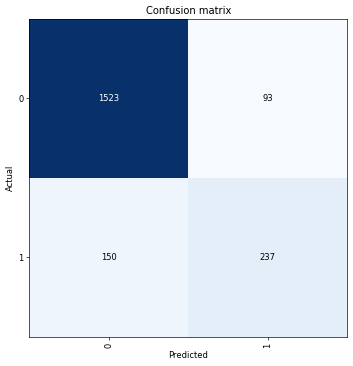

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)